In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import curve_fit

def dxdt(x, y, sigma=10):
    return sigma * (y - x)

def dydt(x, y, z, rho=28):
    return x * (rho - z) - y

def dzdt(x, y, z, beta=8/3):
    return x * y - beta * z

def RK2(x0, y0, z0, time_steps, dt):
    n = round(time_steps / dt)
    y = y0
    x = x0
    z = z0
    hist = []
    
    for i in tqdm(range(1, n+1)):
        hist.append([x, y, z])
        xk1 = dxdt(x, y)
        yk1 = dydt(x, y, z)
        zk1 = dzdt(x, y, z)
        xk2 = dxdt(x + xk1 * dt, y + yk1 * dt)
        yk2 = dydt(x + xk1 * dt, y + yk1 * dt, z + zk1 * dt)
        zk2 = dzdt(x + xk1 * dt, y + yk1 * dt, z + zk1 * dt)
        x += (xk1 + xk2) / 2 * dt
        y += (yk1 + yk2) / 2 * dt
        z += (zk1 + zk2) / 2 * dt
    
    return np.array(hist)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

def ly_exp_lin(t, a, lyp):
    return a + lyp * t

def ly_exp(t, a, lyp):
    return np.exp(ly_exp_lin(t, a, lyp))


In [2]:
dt = 0.0001
time_steps = 25
epsilon = 1e-9
x0, y0, z0 = 2, 3, -14
hist1 = RK2(x0, y0, z0, time_steps, dt)
hist2 = RK2(x0, y0, z0 + epsilon, time_steps, dt)
# dist = sqrt(dx^2 + dy^2 + dz^2)
distances = np.sqrt((np.abs(hist1 - hist2) ** 2).sum(axis = 1)) 
log_dist = np.log(distances)
params, cv = curve_fit(ly_exp_lin, np.linspace(0, time_steps, round(time_steps / dt)), log_dist, [epsilon, 0])
print (params, cv)

100%|██████████| 250000/250000 [00:00<00:00, 313444.81it/s]


[ 9.08221110e-10 -1.52805047e-09] [[ 1.27700298e-02 -3.77543461e-05]
 [-3.77543461e-05  2.66066758e-06]]


Text(0.5, 0, 'Z Axis')

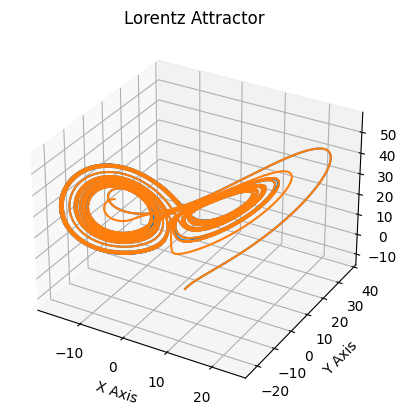

In [4]:
plt.figure(1)
ax = plt.axes(projection='3d')
ax.plot(*hist1.T)
ax.plot(*hist2.T)
ax.set_title('Lorentz Attractor')
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')


Text(0.3, 0.7, '$y=0.00e^{-0.00t}$')

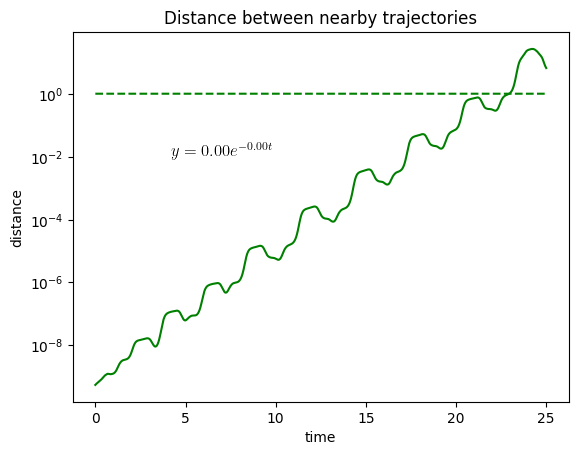

In [5]:
plt.figure(2)
ax = plt.axes()
ax.set_yscale('log')
window = 1000
ax.plot(np.linspace(0, time_steps, round(time_steps / dt)), moving_average(distances, 10000), 'g')
plt.title('Distance between nearby trajectories')
plt.xlabel('time')
plt.ylabel('distance')
xs = np.linspace(0, time_steps, round(time_steps / dt))
ys = [ly_exp(t, *params) for t in xs]
ax.plot(xs, ys, 'g--')
equation_string = f'$y={params[0]:.2f}e^{{{params[1]:.2f}t}}$'
plt.text(0.3, 0.7, equation_string, horizontalalignment='center',
    verticalalignment='top', transform=ax.transAxes, usetex=True, fontsize=12) 